# Modeling and training 

In [1]:
import numpy as np
import random 
import os 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Conv2D, MaxPool2D, Dense, ZeroPadding2D, Dropout
from tensorflow.keras.utils import to_categorical, img_to_array, load_img 
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import LambdaCallback

In [2]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [3]:
X_train, y_train = load_mnist('fashionmnist', kind='train')
X_test, y_test = load_mnist('fashionmnist', kind='t10k')

In [4]:
X_test.shape

(10000, 784)

In [5]:
X_train = X_train.reshape(X_train.shape[0], 28, 28)
X_test = X_test.reshape(X_test.shape[0], 28, 28)

In [6]:
X_train.shape

(60000, 28, 28)

In [7]:
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

In [8]:
X_train.shape

(60000, 28, 28, 1)

In [9]:
X_train[1000]

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 97],
        [ 84],
        [ 97],
        [110],
        [108],
        [ 87],
        [ 97],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 19],
        [255],
        [199],
        [183],
        [142],
        [161],
        [200],
        [213],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
      

In [10]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
model = Sequential([
    ZeroPadding2D(padding=(1, 1), input_shape=(28, 28, 1)),
    Conv2D(32, 3, activation='relu'),
    Dropout(0.2),
    MaxPool2D(pool_size=2, strides=2),
    ZeroPadding2D(padding=(1, 1)),
    Conv2D(64, 3, activation='relu'),
    Dropout(0.2),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 30, 30, 1)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                        

In [12]:
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

callback

In [13]:
class SaveLayerOutputs(tf.keras.callbacks.Callback):
    def __init__(self, model, output_folder):
        self.model = model
        self.output_folder = output_folder
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        layer_outputs = [layer.output for layer in self.model.layers]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)

        for i, layer in enumerate(self.model.layers):
            layer_name = layer.name
            intermediate_output_model = Model(inputs=self.model.input, outputs=layer.output)
            layer_output = intermediate_output_model.predict(X_test[0].reshape(1, 28, 28, 1))
            np.save(os.path.join(self.output_folder, f'epoch_{epoch + 1}_{layer_name}_output.npy'), layer_output)
            print(f'Saved output of layer {layer_name} after epoch {epoch + 1}.')

training and saving

In [14]:
output_folder = './layer_outputs'
os.makedirs(output_folder, exist_ok=True)

callbacks = [
    SaveLayerOutputs(model, output_folder)
]

model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train_ohe, epochs=5, callbacks=callbacks, validation_data=(X_test, y_test_ohe), batch_size = 300)

Epoch 1/5
1/1 [==============================] - 0s 63ms/step- loss: 0.6602 - accuracy: 0.76
Saved output of layer zero_padding2d after epoch 1.
1/1 [==============================] - 0s 47ms/step
Saved output of layer conv2d after epoch 1.
1/1 [==============================] - 0s 47ms/step
Saved output of layer dropout after epoch 1.
1/1 [==============================] - 0s 47ms/step
Saved output of layer max_pooling2d after epoch 1.
1/1 [==============================] - 0s 47ms/step
Saved output of layer zero_padding2d_1 after epoch 1.
1/1 [==============================] - 0s 63ms/step
Saved output of layer conv2d_1 after epoch 1.
1/1 [==============================] - 0s 62ms/step
Saved output of layer dropout_1 after epoch 1.
1/1 [==============================] - 0s 47ms/step
Saved output of layer max_pooling2d_1 after epoch 1.
1/1 [==============================] - 0s 62ms/step
Saved output of layer flatten after epoch 1.
1/1 [==============================] - 0s 62ms/step
Sa

<AxesSubplot: >

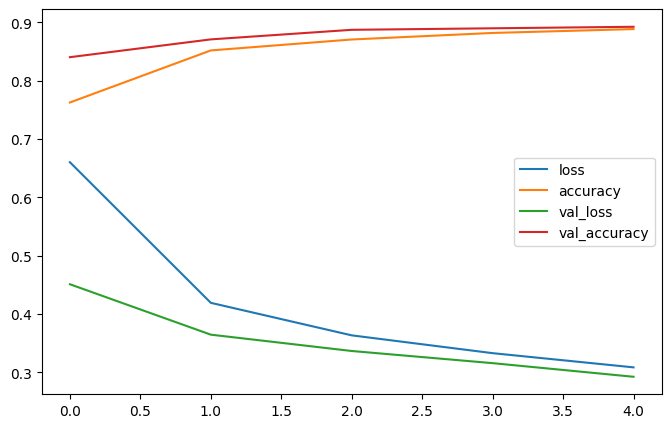

In [15]:
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
pd.DataFrame(history.history).plot(figsize=(8,5))

In [16]:
history.history

{'loss': [0.6602469682693481,
  0.4193122386932373,
  0.3635813891887665,
  0.33305713534355164,
  0.308729887008667],
 'accuracy': [0.762583315372467,
  0.8517833352088928,
  0.8705166578292847,
  0.8817166686058044,
  0.8883500099182129],
 'val_loss': [0.4511435031890869,
  0.36475375294685364,
  0.33677938580513,
  0.3159509301185608,
  0.29259905219078064],
 'val_accuracy': [0.8402000069618225,
  0.8707000017166138,
  0.8870999813079834,
  0.8896999955177307,
  0.892300009727478]}

In [17]:
model.save('masoud.h5')

In [18]:
# MasoudKaviani.ir

# Monitoring feature maps after each layer

In [19]:
def plot_saved_feature_maps(output_folder, layer_name, epoch):

    file_path = os.path.join(output_folder, f'epoch_{epoch + 1}_{layer_name}_output.npy')
    feature_map = np.load(file_path)
    
    plt.figure(figsize=(10, 10))
    for i in range(feature_map.shape[-1]):
        plt.subplot(8, 8, i+1) 
        plt.imshow(feature_map[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Layer {layer_name} Feature Maps')
    plt.show()

plotting the outputs of layers (last epoch) 

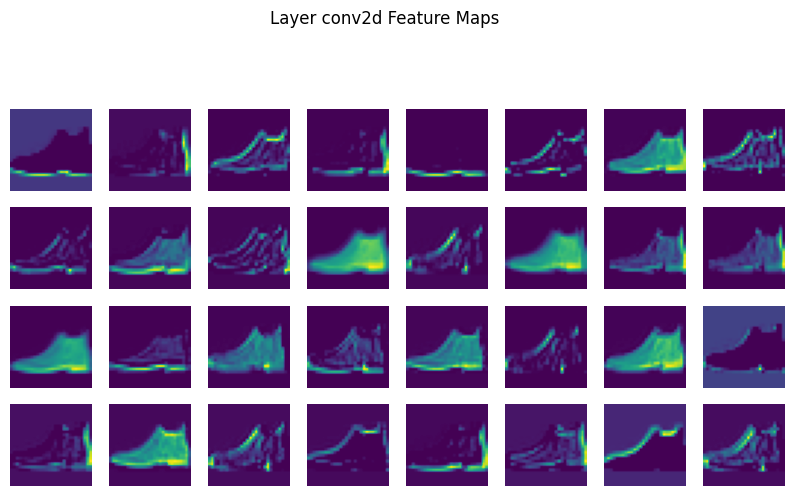

In [20]:
plot_saved_feature_maps(output_folder, 'conv2d', 4)

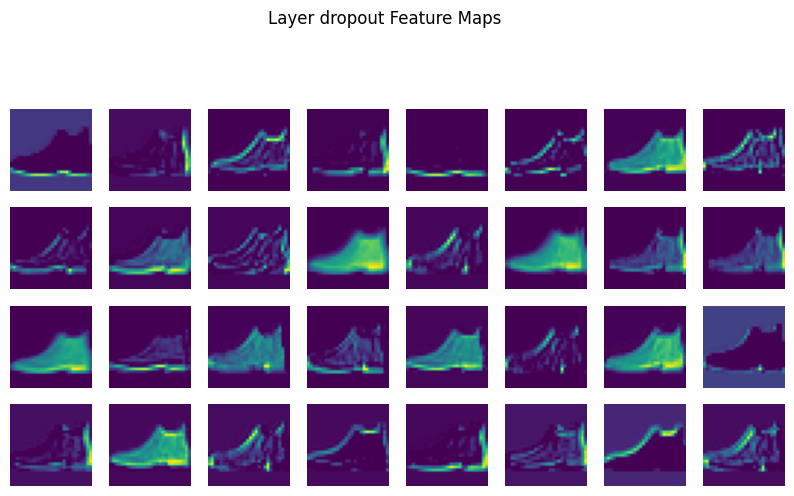

In [21]:
plot_saved_feature_maps(output_folder, 'dropout', 4)

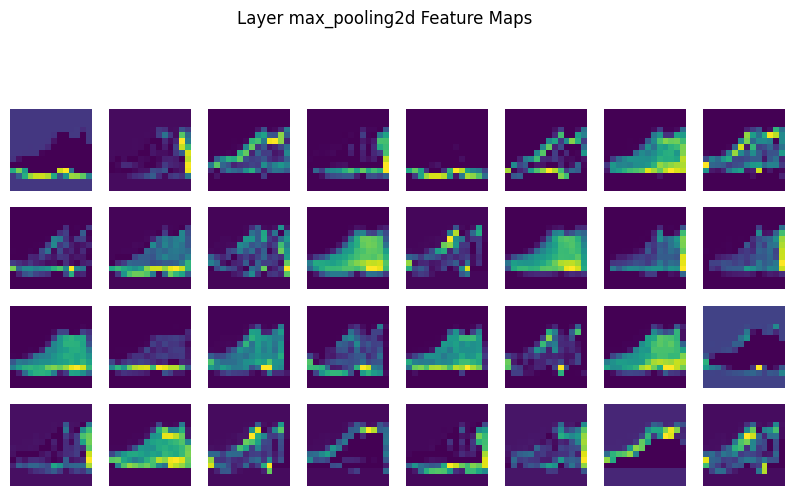

In [22]:
plot_saved_feature_maps(output_folder, 'max_pooling2d', 4)

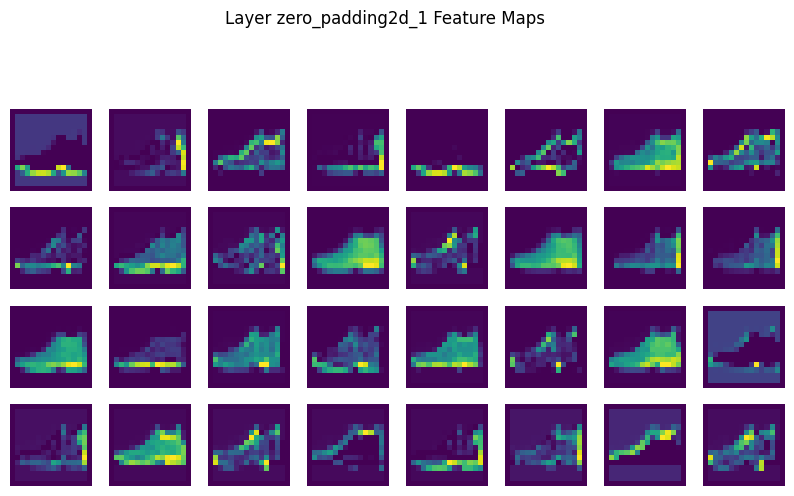

In [23]:
plot_saved_feature_maps(output_folder, 'zero_padding2d_1', 4)

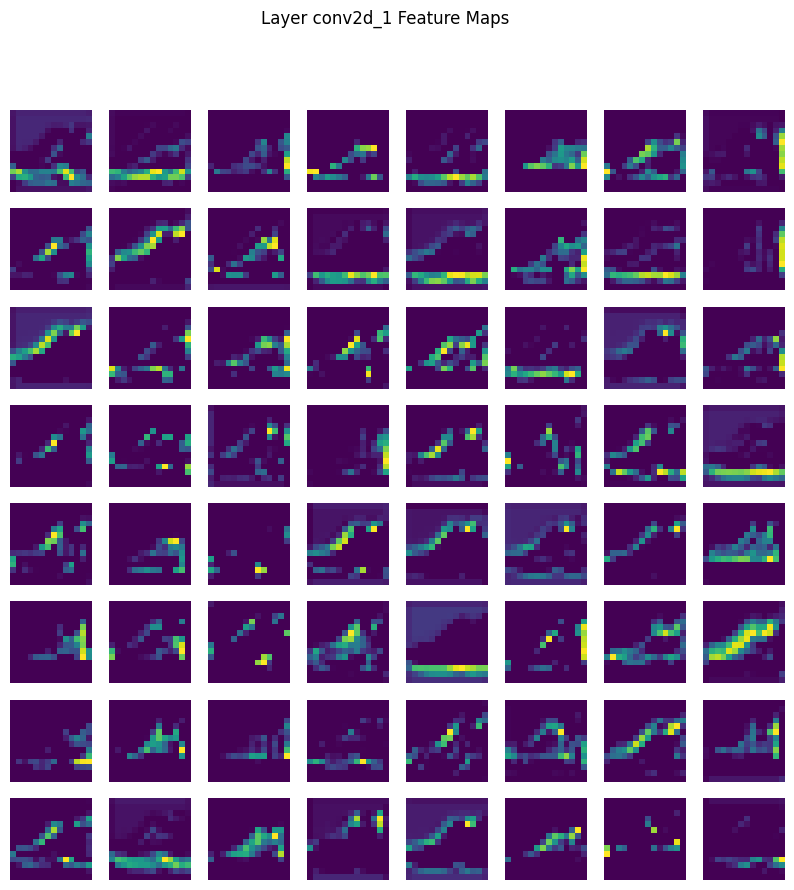

In [24]:
plot_saved_feature_maps(output_folder, 'conv2d_1', 4)

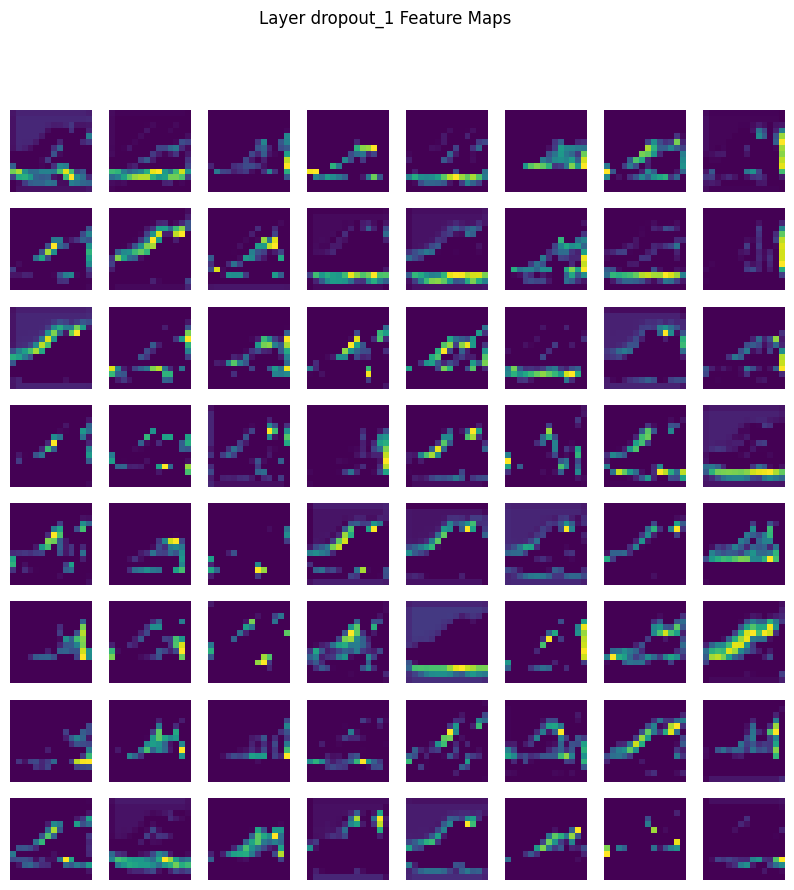

In [25]:
plot_saved_feature_maps(output_folder, 'dropout_1', 4)

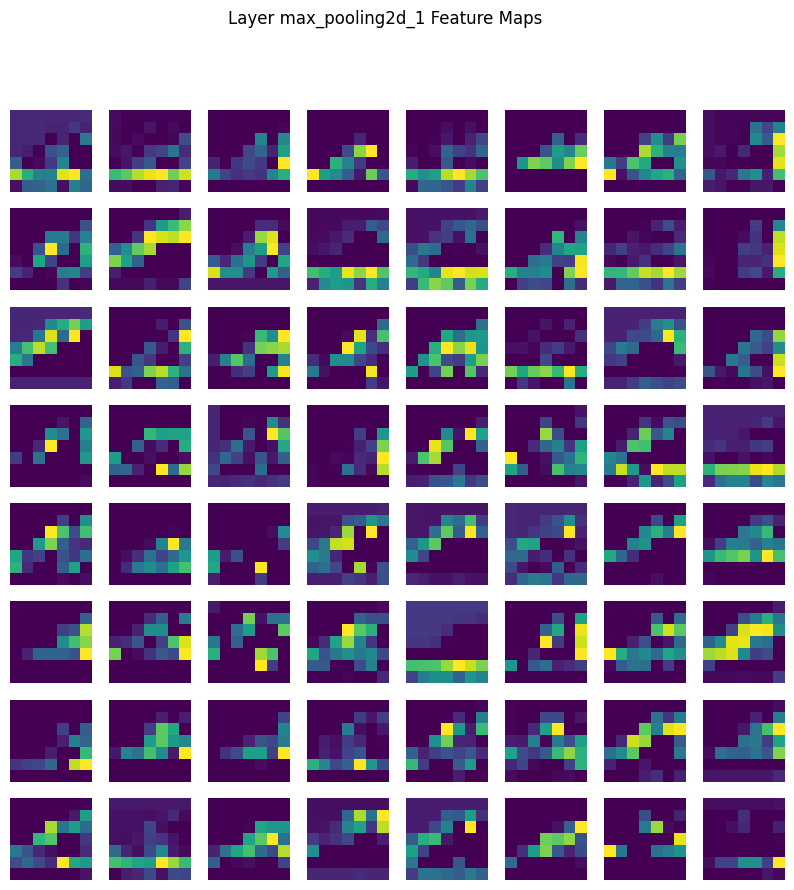

In [26]:
plot_saved_feature_maps(output_folder, 'max_pooling2d_1', 4)